## 7th Laboratory - 6th exercise

Solve the **task at 1.** by writing and executing a **stand-alone Spark application in python**

In [1]:
sc

''

In [2]:
!echo $SPARK_HOME

### Environment configuration

In [3]:
!pip install findspark

In [4]:
import findspark
findspark.init('/usr/local/Cellar/apache-spark/3.0.1/libexec')

from pyspark import SparkContext, SparkConf

conf = SparkConf().setMaster("local").setAppName("My App")
sc = SparkContext(conf = conf)

In [5]:
!echo $SPARK_HOME

/usr/local/Cellar/apache-spark/3.0.1/libexec


### 1st task solution

In [6]:
import re

In [7]:
counts = sc.textFile('./data/shakespeare/*')\
             .flatMap(lambda line: re.split('\W+', line))\
             .map(lambda word: (word, 1)) \
             .filter(lambda x: x[0] != "")\
             .reduceByKey(lambda a, b: a + b) \

counts.coalesce(1)\
      .sortBy(lambda a: a[0])\
      .saveAsTextFile("./lab7/counts_stand_alone_app")

In [8]:
f = open("./lab7/counts_stand_alone_app/part-00000", "r")
file_content = f.read()
f.close()

print(file_content[:390])

('1', 49)
('10', 1)
('11th', 1)
('12th', 1)
('1s', 1)
('2', 48)
('2d', 1)
('2s', 3)
('3', 29)
('4', 1)
('4d', 1)
('5', 1)
('5s', 1)
('6', 1)
('6d', 2)
('6s', 1)
('7', 1)
('8', 1)
('8d', 2)
('9', 1)
('A', 2027)
('AARON', 72)
('ABATE', 1)
('ABATEMENT', 1)
('ABERGAVENNY', 9)
('ABHOR', 1)
('ABHORSON', 18)
('ABIDE', 1)
('ABLE', 1)
('ABOUT', 18)
('ABRAHAM', 7)
('ABRIDGEMENT', 1)
('ABROAD', 1)



## 7th Laboratory - 7th exercise

Write a standalone spark application to **implement k-Means**. The application will take two
arguments: the input data file and the output directory where only the centroids will be printed.
Because every iteration is working with the data set, persist it. 

### Using pyspark.ml and a default dataset

In [9]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.session import SparkSession

# Loads data.
spark = SparkSession(sc)
dataset = spark.read.format("libsvm").load("/usr/local/Cellar/apache-spark/3.0.1/libexec/data/mllib/sample_kmeans_data.txt")

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(dataset)

# Make predictions
predictions = model.transform(dataset)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.9997530305375207
Cluster Centers: 
[9.1 9.1 9.1]
[0.1 0.1 0.1]


In [10]:
dataset.take(100)

[Row(label=0.0, features=SparseVector(3, {})),
 Row(label=1.0, features=SparseVector(3, {0: 0.1, 1: 0.1, 2: 0.1})),
 Row(label=2.0, features=SparseVector(3, {0: 0.2, 1: 0.2, 2: 0.2})),
 Row(label=3.0, features=SparseVector(3, {0: 9.0, 1: 9.0, 2: 9.0})),
 Row(label=4.0, features=SparseVector(3, {0: 9.1, 1: 9.1, 2: 9.1})),
 Row(label=5.0, features=SparseVector(3, {0: 9.2, 1: 9.2, 2: 9.2}))]

## Implementing K-means from scratch

In [11]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import math

### Data generation

I will generate a 2-dimensional dataset, clustered in 3 clusters.

In [12]:
first_cluster = list(set([(random.randint(-10, -2), random.randint(-10, -2)) for i in range(20)]))
second_cluster = list(set([(random.randint(10, 20), random.randint(10, 20)) for i in range(20)]))
third_cluster = list(set([(random.randint(30, 40), random.randint(30, 40)) for i in range(20)]))

In [13]:
all_data = first_cluster + second_cluster + third_cluster
len(all_data)

57

In [14]:
df = pd.DataFrame({
    "x": [coord[0] for coord in all_data],
    "y": [coord[1] for coord in all_data]
})
df.head()

,x,y
0,-9,-8
1,-3,-2
2,-5,-9
3,-2,-2
4,-4,-6


In [15]:
df.to_csv('./k-means_data/data20.csv', index=None, header=False)

### Data visualization to check if the data is clustered

In [16]:
df5 = pd.read_csv('./k-means_data/data5.csv', header=None)
df20 = pd.read_csv('./k-means_data/data20.csv', header=None)

In [17]:
df20.head()

,0,1
0,-9,-8
1,-3,-2
2,-5,-9
3,-2,-2
4,-4,-6


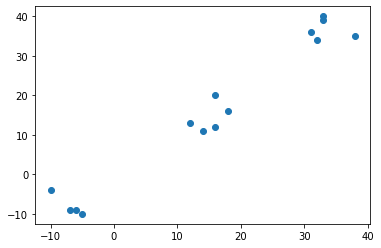

In [18]:
plt.scatter(df5[0], df5[1])

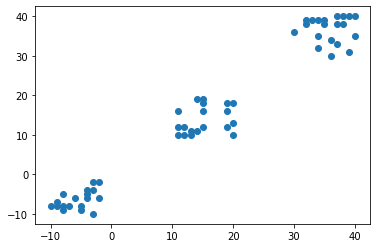

In [19]:
plt.scatter(df20[0], df20[1])

### K-means implementation

In [20]:
def compute_euclidian_distance(first, second):
    return math.sqrt((first[0] - second[0])**2 + (first[1] - second[1])**2)

compute_euclidian_distance((1, 2), (2, 3))

1.4142135623730951

In [21]:
K = 3

def establish_initial_centroids_index(centroids_number, index_column):
    centroid_indexes = []
    while len(centroid_indexes) < 3:
        current = random.choice(list(index_column))
        while current in centroid_indexes:
            current = random.choice(list(index_column))
        centroid_indexes.append(current)
    return centroid_indexes


establish_initial_centroids_index(3, df5.index)

[10, 8, 0]

In [22]:
def get_cluster_index_given_point_and_centroids(p, centroids):
    closest_centroid = 0
    smallest_distance = None
    for i in range(len(centroids)):
        current_distance = compute_euclidian_distance(p, centroids[i])
        if smallest_distance == None:
            closest_centroid = i
            smallest_distance = current_distance
        if current_distance < smallest_distance:
            closest_centroid = i
            smallest_distance = current_distance
    return closest_centroid

In [23]:
def compute_coordinates_new_centroid(points_list):
    x = []
    y = []
    for point in points_list:
        x.append(point[0])
        y.append(point[1])
    return (sum(x) / len(x), sum(y) / len(y))

In [24]:
rdd5 =  sc.textFile('./k-means_data/data5.csv')\
        .map(lambda x: str(x)) \
        .map(lambda w: w.split(',')) \
        .map(lambda point: (eval(point[0]), eval(point[1])))

print(rdd5.take(2))

[(-5, -10), (-10, -4)]


In [25]:
rdd5.count()

14

In [26]:
initial_centroids_indexes = establish_initial_centroids_index(3, range(rdd5.count()))
initial_centroids_indexes

[5, 10, 4]

In [27]:
rdd5.zipWithIndex().take(2)

[((-5, -10), 0), ((-10, -4), 1)]

In [29]:
initial_centroids_coordinates = rdd5.zipWithIndex()\
                                    .filter(lambda point_index: point_index[1] in initial_centroids_indexes)\
                                    .map(lambda point_index: point_index[0])\
                                    .collect()
initial_centroids_coordinates

[(16, 20), (18, 16), (33, 39)]

In [30]:
get_cluster_index_given_point_and_centroids((16, 12), initial_centroids_coordinates)

1

In [31]:
centroids_coords = initial_centroids_coordinates

rdd5.map(lambda point: (get_cluster_index_given_point_and_centroids(point, initial_centroids_coordinates), point))\
    .collect()

[(1, (-5, -10)),
 (1, (-10, -4)),
 (1, (-7, -9)),
 (1, (-6, -9)),
 (0, (16, 20)),
 (1, (18, 16)),
 (1, (12, 13)),
 (1, (16, 12)),
 (1, (14, 11)),
 (2, (32, 34)),
 (2, (33, 39)),
 (2, (38, 35)),
 (2, (31, 36)),
 (2, (33, 40))]

In [32]:
rdd5.map(lambda point: (get_cluster_index_given_point_and_centroids(point, initial_centroids_coordinates), point))\
    .groupByKey()\
    .map(lambda cluster_points_list: (cluster_points_list[0], 
                                      compute_coordinates_new_centroid(cluster_points_list[1])))\
    .collect()

[(1, (4.0, 2.5)), (0, (16.0, 20.0)), (2, (33.4, 36.8))]

In [33]:
new_centroids_coordinates = rdd5.map(lambda point: \
                         (get_cluster_index_given_point_and_centroids(point, initial_centroids_coordinates), point))\
    .groupByKey()\
    .map(lambda cluster_points_list: (cluster_points_list[0], 
                                      compute_coordinates_new_centroid(cluster_points_list[1])))\
    .map(lambda cluster_centroid_coordinates: cluster_centroid_coordinates[1])\
    .collect()

new_centroids_coordinates

[(4.0, 2.5), (16.0, 20.0), (33.4, 36.8)]

In [34]:
def get_new_centroid_coordinates(rdd):
    return rdd.groupByKey()\
              .map(lambda cluster_points_list: (cluster_points_list[0], 
                                      compute_coordinates_new_centroid(cluster_points_list[1])))\
              .map(lambda cluster_centroid_coordinates: cluster_centroid_coordinates[1])\
              .collect()

def compute_variance_for_given_cluster(cluster_point, list_of_points):
    return sum([compute_euclidian_distance(cluster_point, point) for point in list_of_points])


def get_variance_within_each_cluster(rdd, current_configuration):
    return rdd.groupByKey()\
              .map(lambda cluster_index_points_list: (cluster_index_points_list[0],
                          compute_variance_for_given_cluster(current_configuration[cluster_index_points_list[0]],
                                                            cluster_index_points_list[1])))\
              .collect()


def K_means(rdd, k, initial_centroids_indexes, verbose=False):

    # get the coordinates for the initial centroids
    initial_centroids_coordinates = rdd.zipWithIndex()\
                                        .filter(lambda point_index: point_index[1] in initial_centroids_indexes)\
                                        .map(lambda point_index: point_index[0])\
                                        .collect()

    # modify the rdd so that each point is assigned to the closest centroid from the initial chosen ones
    rdd = rdd.map(lambda point: (get_cluster_index_given_point_and_centroids(point, current_configuration), point))


    # iterate until we encounter the same K-configuration, and implicitly the same K-partition as the one from the 
    # previous step

    current_configuration = initial_centroids_coordinates
    prev_configuration = None

    while current_configuration != prev_configuration:
        prev_configuration = current_configuration

        rdd = rdd.map(lambda cluster_point: \
                        (get_cluster_index_given_point_and_centroids(cluster_point[1], prev_configuration), 
                         cluster_point[1]))

        current_configuration = get_new_centroid_coordinates(rdd)

        if verbose:
            print('Previous configuration', prev_configuration)
            print('Next configuration', current_configuration)
            print(rdd.collect())
            print('\n\n')

    variance_within_clusters = get_variance_within_each_cluster(rdd, current_configuration)
    variance_summed = sum([cluster_variance[1] for cluster_variance in variance_within_clusters])
    
    if verbose:
        # convert the rdd to a pandas dataframe and visualize the results in a scatter plot
        pd_df = rdd.map(lambda cluster_point: [cluster_point[1][0], cluster_point[1][1], cluster_point[0]])\
                .toDF(["x", "y", "cluster_index"]).toPandas()
        
        print(pd_df.head())
        print('\n\n')

        plt.scatter(pd_df['x'], pd_df['y'], c=pd_df['cluster_index'])
        plt.show()
        
    return variance_summed

In [35]:
import tqdm

K=3
filename = './k-means_data/data5.csv'
stopping_variance = 1.0
stopping_iterations = 10


def run_optimized_k_means(filename, k, stopping_iterations):
    # read data and cast from string to numbers
    rdd =  sc.textFile(filename)\
            .map(lambda x: str(x)) \
            .map(lambda w: w.split(',')) \
            .map(lambda point: (eval(point[0]), eval(point[1])))

    iteration = 0
    best_initial_clusters_indexes = None
    min_variance = None

    while iteration < stopping_iterations or current_variance == stopping_variance:

        # establish randomly the indexes for the first K centroids
        initial_centroids_indexes = establish_initial_centroids_index(K, range(rdd.count()))
        current_variance = K_means(rdd, K, initial_centroids_indexes)

        if min_variance == None:
            best_initial_clusters_indexes = initial_centroids_indexes
            min_variance = current_variance
        elif min_variance > current_variance:
            print("Improved variance at iteration = " + str(iteration) + ' with the initial cluster indexes ' +
                  str(initial_centroids_indexes))
            best_initial_clusters_indexes = initial_centroids_indexes
            min_variance = current_variance

        iteration += 1
    
    return best_initial_clusters_indexes


def run_unoptimized_kmeans(filename, k, verbose=False):
    # read data and cast from string to numbers
    rdd =  sc.textFile(filename)\
            .map(lambda x: str(x)) \
            .map(lambda w: w.split(',')) \
            .map(lambda point: (eval(point[0]), eval(point[1])))
    
    # establish randomly the indexes for the first K centroids
    initial_centroids_indexes = establish_initial_centroids_index(K, range(rdd.count()))
    K_means(rdd, K, best_initial_clusters_indexes, verbose)

Improved variance at iteration = 1 with the initial cluster indexes [1, 11, 7]
Previous configuration [(-10, -4), (16, 12), (38, 35)]
Next configuration [(-7.0, -8.0), (15.2, 14.4), (33.4, 36.8)]
[(0, (-5, -10)), (0, (-10, -4)), (0, (-7, -9)), (0, (-6, -9)), (1, (16, 20)), (1, (18, 16)), (1, (12, 13)), (1, (16, 12)), (1, (14, 11)), (2, (32, 34)), (2, (33, 39)), (2, (38, 35)), (2, (31, 36)), (2, (33, 40))]



Previous configuration [(-7.0, -8.0), (15.2, 14.4), (33.4, 36.8)]
Next configuration [(-7.0, -8.0), (15.2, 14.4), (33.4, 36.8)]
[(0, (-5, -10)), (0, (-10, -4)), (0, (-7, -9)), (0, (-6, -9)), (1, (16, 20)), (1, (18, 16)), (1, (12, 13)), (1, (16, 12)), (1, (14, 11)), (2, (32, 34)), (2, (33, 39)), (2, (38, 35)), (2, (31, 36)), (2, (33, 40))]



    x   y  cluster_index
0  -5 -10              0
1 -10  -4              0
2  -7  -9              0
3  -6  -9              0
4  16  20              1





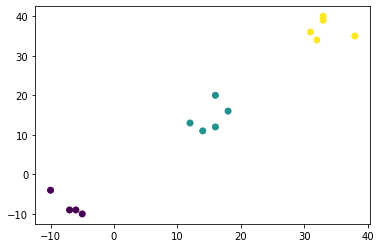

44.81354526638938

In [36]:
best_initial_clusters_indexes = run_optimized_k_means('./k-means_data/data5.csv', K, stopping_iterations)

rdd = sc.textFile('./k-means_data/data5.csv')\
            .map(lambda x: str(x)) \
            .map(lambda w: w.split(',')) \
            .map(lambda point: (eval(point[0]), eval(point[1])))
K_means(rdd, K, best_initial_clusters_indexes, verbose=True)

Previous configuration [(-3, -2), (-8, -5), (-4, -4)]
Next configuration [(-7.777777777777778, -7.555555555555555), (24.365853658536587, 24.21951219512195), (-3.5714285714285716, -6.142857142857143)]
[(1, (-9, -8)), (0, (-3, -2)), (1, (-5, -9)), (0, (-2, -2)), (2, (-4, -6)), (2, (-2, -6)), (2, (-3, -10)), (1, (-8, -5)), (1, (-9, -7)), (1, (-6, -6)), (1, (-8, -8)), (2, (-4, -4)), (2, (-5, -8)), (2, (-3, -4)), (1, (-8, -9)), (2, (-4, -5)), (1, (-10, -8)), (1, (-7, -8)), (0, (12, 10)), (0, (14, 19)), (0, (19, 12)), (0, (19, 18)), (0, (13, 11)), (0, (20, 13)), (0, (20, 10)), (0, (12, 12)), (0, (11, 10)), (0, (11, 16)), (0, (13, 10)), (0, (15, 16)), (0, (15, 19)), (0, (20, 18)), (0, (14, 11)), (0, (19, 16)), (0, (11, 12)), (0, (15, 12)), (0, (15, 18)), (0, (33, 39)), (0, (35, 39)), (0, (38, 38)), (0, (40, 35)), (0, (37, 33)), (0, (36, 34)), (0, (30, 36)), (0, (32, 39)), (0, (35, 38)), (0, (38, 40)), (0, (40, 40)), (0, (36, 30)), (0, (37, 38)), (0, (34, 39)), (0, (32, 38)), (0, (39, 31)), (0

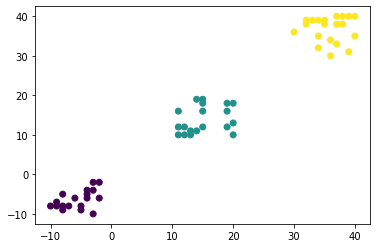

In [37]:
run_unoptimized_kmeans('./k-means_data/data20.csv', k=3, verbose=True)

Previous configuration [(-3, -10), (-9, -7), (11, 10)]
Next configuration [(-7.2, -6.5), (-3.5, -6.25), (25.743589743589745, 25.564102564102566)]
[(1, (-9, -8)), (1, (-3, -2)), (0, (-5, -9)), (0, (-2, -2)), (0, (-4, -6)), (0, (-2, -6)), (0, (-3, -10)), (1, (-8, -5)), (1, (-9, -7)), (1, (-6, -6)), (1, (-8, -8)), (1, (-4, -4)), (0, (-5, -8)), (0, (-3, -4)), (1, (-8, -9)), (0, (-4, -5)), (1, (-10, -8)), (1, (-7, -8)), (2, (12, 10)), (2, (14, 19)), (2, (19, 12)), (2, (19, 18)), (2, (13, 11)), (2, (20, 13)), (2, (20, 10)), (2, (12, 12)), (2, (11, 10)), (2, (11, 16)), (2, (13, 10)), (2, (15, 16)), (2, (15, 19)), (2, (20, 18)), (2, (14, 11)), (2, (19, 16)), (2, (11, 12)), (2, (15, 12)), (2, (15, 18)), (2, (33, 39)), (2, (35, 39)), (2, (38, 38)), (2, (40, 35)), (2, (37, 33)), (2, (36, 34)), (2, (30, 36)), (2, (32, 39)), (2, (35, 38)), (2, (38, 40)), (2, (40, 40)), (2, (36, 30)), (2, (37, 38)), (2, (34, 39)), (2, (32, 38)), (2, (39, 31)), (2, (39, 40)), (2, (34, 35)), (2, (34, 32)), (2, (37, 40

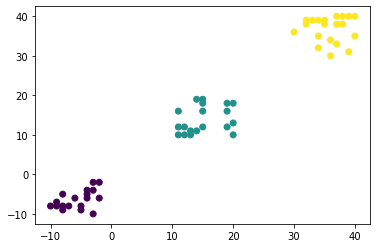

220.65439591148163

In [38]:
best_initial_clusters_indexes = run_optimized_k_means('./k-means_data/data20.csv', k=3, stopping_iterations=100)

rdd = sc.textFile('./k-means_data/data20.csv')\
            .map(lambda x: str(x)) \
            .map(lambda w: w.split(',')) \
            .map(lambda point: (eval(point[0]), eval(point[1])))

K_means(rdd, K, best_initial_clusters_indexes, verbose=True)